# Data Preape 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from alibi.explainers import IntegratedGradients
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model
from nltk.tokenize import word_tokenize
from tensorflow.keras import layers
from nltk.corpus import stopwords
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from numpy.random import seed
import matplotlib as mpl
import tensorflow as tf
import pandas as pd 
import numpy as np
import datetime
import random
import re
import os

ORIGINAL_DATA = "Merged_data.csv"
EMBEDDING_DROPOUT = 0.22934054397801462  
LEARNING_RATE =  0.00142
MAX_WORD_LENGTH = 23
LAYER_DROP = 0.3
INIT_SEED = 12
NODES = 416
EPOCH = 565

c:\Users\Assaf\miniconda3\envs\NN_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Reading and seed intializing

In [3]:
df = pd.read_csv(ORIGINAL_DATA,delimiter=",")
tf.keras.utils.set_random_seed(INIT_SEED)
seed(INIT_SEED)
random.seed(INIT_SEED)



In [4]:
def num_stripper(txt):
    return re.sub(r'[^a-zA-Z]', ' ', txt)

## Embedding layrer prep 

### Feature extraction


In [5]:
def pre_processing (clmn): 
    # Tokenizing and stop word removal from column
    procc_str = clmn.apply(lambda txt: [item for item in word_tokenize(num_stripper(txt)) if item.lower() not in stopwords.words('english')])
    # returning the embedding size of column
    embd_size = np.unique([wrd for bag_wrd in procc_str for wrd in bag_wrd ] )
    # Creating inverse dictionary for each unique word
    inv_dict  = dict(zip( embd_size,range(1,embd_size.size+1) ))
    # Return Processed strings and inverse dictionary 
    return [procc_str, inv_dict]

def onehot_padding(data,invs_dict):
    new_df , res  = [],[]
    # Loop over columns in dataframe
    for clmn in data:
        if clmn != 'Url' :
            # One hot encoding each row in column
            res= [[invs_dict[clmn][word] for word in strn] for strn in data[clmn] ]
        else:
            # One hot encoding each row in URL separately due to char removal
            res = [[invs_dict[clmn][key]] for key in data[clmn]]
        new_df.append(res) 
    # Padding sequence to max word length
    new_df = [pad_sequences(clmn,maxlen= MAX_WORD_LENGTH , padding='post')for clmn in new_df]
    return new_df


#### Removing stop words and counting embeding dimension

In [6]:
# Loop over each column in df applying preprocessing  to it 
def df_conversion (df):
    w_dict = {}
    for clmn in df.iloc[:,:-1]:
        x = []
        if clmn not in ['Url' ,'Location' ]:
            df[clmn],w_dict[clmn] = pre_processing (df[clmn])
        elif clmn == 'Location':
            locl_list = [re.split(r',(?=.)', item)  for item in df[clmn]]
            df[clmn] = locl_list
            unique_items = list(set(cnty for county_lst in locl_list for cnty in county_lst))
            w_dict[clmn] = dict(zip(unique_items, range(1,len(unique_items)+1)))
        else:
            url_uniq = df[clmn].unique()
            w_dict[clmn] = dict(zip(url_uniq, range(1,len(url_uniq)+1)))
    return df , w_dict


In [7]:
df ,wrd_dict =  df_conversion(df)

## Model making

In [8]:
def create_model(data,embedding,dense_n):    
    inputs = []
    outputs = []
    # Loop over dataframe to create embedding layer for each feature
    for lst,sze in zip(data , embedding) :
        inp = layers.Input(shape= lst.shape[-1] , name = sze + '_Input')
        embed_dim = int(min(np.ceil(embedding[sze] /2), 45))
        # Defining number of unique values for the embedding layer and the embedding size
        out = layers.Embedding(embedding[sze] + 1, embed_dim, name = sze + '_Embedding' )(inp)
        out = layers.Dropout(EMBEDDING_DROPOUT, name = sze + '_Dropout')(out)
        inputs.append(inp)
        outputs.append(out)
    # Combining the layers
    lyer = layers.Concatenate(name ='Concat_Layer')(outputs)
    lyer = layers.BatchNormalization(name ='BatchnNrmalization_Layer1')(lyer)
    lyer = layers.Flatten(name ='Flatten_Layer')(lyer)
    lyer = layers.Dense(dense_n, activation="relu",name ='Dense_layer')(lyer)
    lyer = layers.Dropout(LAYER_DROP,name ='Dropout_Layer')(lyer)
    lyer = layers.BatchNormalization(name ='BatchnNrmalization_Layer2')(lyer)
    
    res = layers.Dense(1, activation="linear",name ='Output_Layer')(lyer)

    model = Model(inputs=inputs, outputs=res)
    return model

## Test train split

In [9]:
def data_splitting(df):
    X = df.iloc[: ,:-1]
    # Target
    y = df['CTR']
    # # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15 ,random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =  0.25 ,random_state=42)
    # Check the number of records in training and testing dataset.
    print(f'The training dataset shape {len(X_train)} and validation shape {len(X_val)} .')
    print(f'The testing dataset has {len(X_test)} records.')
    return X_train, X_test ,X_val, y_train, y_val ,y_train, y_test


In [10]:
X_train, X_test,X_val,y_train, y_val ,y_train, y_test = data_splitting(df)

The training dataset shape 25 and validation shape 9 .
The testing dataset has 6 records.


#### One hot encoding and padding

In [11]:
# Padding the sets used for the training 
X_train = onehot_padding(X_train,wrd_dict)
X_val = onehot_padding(X_val,wrd_dict)

In [12]:
print(f'The data shape {np.array(X_train).shape}')

The data shape (13, 25, 23)


In [13]:
# Printing the unique word for each feature
embedding_sizes = {x : len(wrd_dict[x]) for x in wrd_dict}
for x in embedding_sizes.items():
    print(x)

('Description', 88)
('Headline', 19)
('Headline.1', 21)
('Location', 15)
('Sitelink', 55)
('Url', 5)
('Callout', 16)
('Callout.1', 17)
('Keyword', 18)
('Keyword.1', 16)
('Keyword.2', 16)
('Keyword.3', 16)
('Keyword.4', 19)


In [14]:
nn = create_model(X_train,embedding_sizes , NODES)   
nn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['mae'])

In [15]:
nn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Description_Input (InputLayer)  [(None, 23)]        0           []                               
                                                                                                  
 Headline_Input (InputLayer)    [(None, 23)]         0           []                               
                                                                                                  
 Headline.1_Input (InputLayer)  [(None, 23)]         0           []                               
                                                                                                  
 Location_Input (InputLayer)    [(None, 23)]         0           []                               
                                                                                              

In [16]:
def train(X_tr,y_tr ,X_v, y_v,verb,batch_s):
    history =  nn.fit(X_tr,
                    y_tr, 
                    validation_data=(X_v, y_v), 
                    epochs=EPOCH, 
                    verbose= verb,
                    batch_size = batch_s,)
    return history

In [17]:
history = train(X_train, y_train ,X_val, y_val,1,0)

Epoch 1/565
1/1 [==============================] - 10s 10s/step - loss: 10.0671 - mae: 2.4048 - val_loss: 12.9847 - val_mae: 3.4008
Epoch 2/565
1/1 [==============================] - 0s 324ms/step - loss: 12.6117 - mae: 2.4860 - val_loss: 13.1109 - val_mae: 3.4202
Epoch 3/565
1/1 [==============================] - 0s 199ms/step - loss: 10.7498 - mae: 2.9160 - val_loss: 12.8383 - val_mae: 3.3789
Epoch 4/565
1/1 [==============================] - 0s 195ms/step - loss: 9.2600 - mae: 2.5054 - val_loss: 12.4465 - val_mae: 3.3190
Epoch 5/565
1/1 [==============================] - 0s 190ms/step - loss: 7.7194 - mae: 2.3831 - val_loss: 12.0769 - val_mae: 3.2616
Epoch 6/565
1/1 [==============================] - 0s 203ms/step - loss: 7.5109 - mae: 2.2971 - val_loss: 11.7083 - val_mae: 3.2061
Epoch 7/565
1/1 [==============================] - 0s 190ms/step - loss: 7.2444 - mae: 2.1554 - val_loss: 11.3811 - val_mae: 3.1593
Epoch 8/565
1/1 [==============================] - 0s 182ms/step - loss: 6

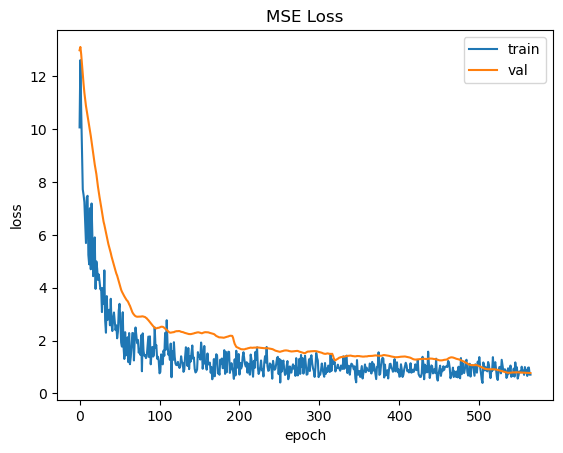

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

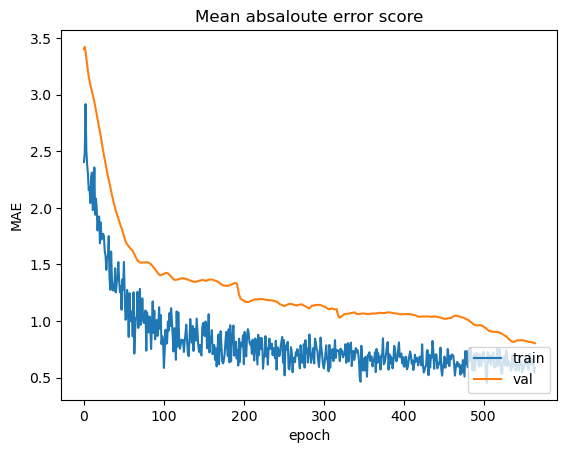

In [19]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean absaloute error score')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Fabrication experiments

In [21]:
PATH_BASE = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/fabricated_data_base.csv'
PATH_EXCTR = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/fabricated_data_extracted_p.csv'
PATH_SIMPLE = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/fabricated_data_simple_p.csv'
PATH_COMPX = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/fabricated_data_advance_p.csv'
PATH_SEM = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/fabricated_data_semantic.csv'
PATH_TRI_SEM = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/tri_data_semantic.csv'
PATH_QUAD_TW_SEM = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/quad2_data_semantic.csv'
PATH_QUAUD_TH_SEM = 'C:/Users/Assaf/Desktop/Thesis-refrences/Code/fabricated_data/tables/quad3_data_semantic.csv'

# Param list for each data set comprised of {dataset name , path to csv , learning rate , batch size , number of nodes}

param_list = {'Simple':[PATH_SIMPLE,0.00027 , 64 , NODES ],
              'Extracted':[PATH_EXCTR , 0.00046 ,64,NODES],
              'Complex':[PATH_COMPX,0.00024,64,NODES],
              'Semantic_tri':[PATH_TRI_SEM,0.00015 , 64 , NODES ],
              'Semantic_quad3':[PATH_QUAUD_TH_SEM,0.0002 , 64 , NODES ],
              'Semantic_quad2':[PATH_QUAD_TW_SEM,0.0002 , 64 , 600 ]}

df_fab = pd.read_csv(PATH_BASE,delimiter=",").iloc[:,:-1]
history_dict = {} 


### Simple pattern training 

In [22]:
# Read CTR for each pattern
df_simple_ctr = pd.read_csv(param_list['Simple'][0],delimiter=",")
# Join fabricated  dataframe with pattern CTR
df_simple_merged = pd.concat([df_fab,df_simple_ctr],axis=1)
# Pre-processing and dictionary extraction
df_simple_merged ,simple_wrd_dict =  df_conversion(df_simple_merged)
# test train split 
X_simple_train, X_simple_test,X_simple_val,y_simple_train, y_simple_val ,y_simple_train, y_simple_test = data_splitting(df_simple_merged)
# # Padding
print(y_simple_train)
X_simple_train = onehot_padding(X_simple_train,simple_wrd_dict)
X_simple_val = onehot_padding(X_simple_val,simple_wrd_dict)
embedding_sizes_simple = {x : len(simple_wrd_dict[x]) for x in simple_wrd_dict}
# Create model
nn = create_model(X_simple_train,embedding_sizes_simple,param_list['Simple'][3])   
nn.compile(loss= 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=param_list['Simple'][1]), metrics=['mae'])
# Training the model 
history_dict ['Simple'] = train(X_simple_train, y_simple_train ,X_simple_val, y_simple_val,0,param_list['Simple'][2])

The training dataset shape 255 and validation shape 85 .
The testing dataset has 60 records.
369    1.991847
274    0.129512
105    0.366869
211    4.488592
358    1.732435
         ...   
249    1.796617
145    3.880229
377    1.435637
43     3.811789
286    2.653224
Name: CTR, Length: 255, dtype: float64


### Extracted pattern training 

In [23]:
# Read CTR for each pattern
df_extr_ctr = pd.read_csv(param_list['Extracted'][0],delimiter=",")
# Join fabricated  dataframe with pattern CTR
df_extr_merged = pd.concat([df_fab,df_extr_ctr],axis=1)
# Pre-processing and dictionary extraction
df_extr_merged ,extr_wrd_dict =  df_conversion(df_extr_merged)
# test train split 
X_extr_train, X_extr_test,X_extr_val,y_extr_train, y_extr_val ,y_extr_train, y_extr_test = data_splitting(df_extr_merged)
# Padding
X_extr_train = onehot_padding(X_extr_train,extr_wrd_dict)
X_extr_val = onehot_padding(X_extr_val,extr_wrd_dict)
embedding_sizes_extr = {x : len(extr_wrd_dict[x]) for x in extr_wrd_dict}
# Create model
nn = create_model(X_extr_train,embedding_sizes_extr,param_list['Extracted'][3])   
nn.compile(loss= 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=param_list['Extracted'][1]), metrics=['mae'])
# Training the model 
history_dict ['Extracted'] = train(X_extr_train, y_extr_train ,X_extr_val, y_extr_val,0,param_list['Extracted'][2])

The training dataset shape 255 and validation shape 85 .
The testing dataset has 60 records.


### Complex pattern training 

In [24]:
# Read CTR for each pattern
df_compl_ctr = pd.read_csv(param_list['Complex'][0],delimiter=",")
# Join fabricated  dataframe with pattern CTR
df_compl_merged = pd.concat([df_fab,df_compl_ctr],axis=1)
# Pre-processing and dictionary complaction
df_compl_merged ,compl_wrd_dict =  df_conversion(df_compl_merged)
# test train split 
X_compl_train, X_compl_test,X_compl_val,y_compl_train, y_compl_val ,y_compl_train, y_compl_test = data_splitting(df_compl_merged)
# Padding
X_compl_train = onehot_padding(X_compl_train,compl_wrd_dict)
X_compl_val = onehot_padding(X_compl_val,compl_wrd_dict)
embedding_sizes_compl = {x : len(compl_wrd_dict[x]) for x in compl_wrd_dict}
# Create model
nn = create_model(X_compl_train,embedding_sizes_compl,param_list['Complex'][3])   
nn.compile(loss= 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=param_list['Complex'][1]), metrics=['mae'])
# Training the model 
history_dict ['Complex'] = train(X_compl_train, y_compl_train ,X_compl_val, y_compl_val,0,param_list['Complex'][2])

The training dataset shape 255 and validation shape 85 .
The testing dataset has 60 records.


### One to two pattern training 

In [25]:
# Read CTR for each pattern
df_sem_one_two_ctr = pd.read_csv(param_list['Semantic_tri'][0],delimiter=",")
# Join fabricated  dataframe with pattern CTR
df_sem_one_two_merged = pd.concat([df_fab,df_sem_one_two_ctr],axis=1)
# Pre-processing and dictionary sem_one_twoaction
df_sem_one_two_merged ,sem_one_two_wrd_dict =  df_conversion(df_sem_one_two_merged)
# test train split 
X_sem_one_two_train, X_sem_one_two_test,X_sem_one_two_val,y_sem_one_two_train, y_sem_one_two_val ,y_sem_one_two_train, y_sem_one_two_test = data_splitting(df_sem_one_two_merged)
# Padding
X_sem_one_two_train = onehot_padding(X_sem_one_two_train,sem_one_two_wrd_dict)
X_sem_one_two_val = onehot_padding(X_sem_one_two_val,sem_one_two_wrd_dict)
embedding_sizes_sem_one_two = {x : len(sem_one_two_wrd_dict[x]) for x in sem_one_two_wrd_dict}
# Create model
nn = create_model(X_sem_one_two_train,embedding_sizes_sem_one_two,param_list['Semantic_tri'][3])   
nn.compile(loss= 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=param_list['Semantic_tri'][1]), metrics=['mae'])
# Training the model 
history_dict ['Semantic_tri'] = train(X_sem_one_two_train, y_sem_one_two_train ,X_sem_one_two_val, y_sem_one_two_val,0,param_list['Semantic_tri'][2])

The training dataset shape 255 and validation shape 85 .
The testing dataset has 60 records.


### One to three pattern training 

In [26]:
# Read CTR for each pattern
df_sem_one_thee_ctr = pd.read_csv(param_list['Semantic_quad3'][0],delimiter=",")
# Join fabricated  dataframe with pattern CTR
df_sem_one_thee_merged = pd.concat([df_fab,df_sem_one_thee_ctr],axis=1)
# Pre-processing and dictionary sem_one_theeaction
df_sem_one_thee_merged ,sem_one_thee_wrd_dict =  df_conversion(df_sem_one_thee_merged)
# test train split 
X_sem_one_thee_train, X_sem_one_thee_test,X_sem_one_thee_val,y_sem_one_thee_train, y_sem_one_thee_val ,y_sem_one_thee_train, y_sem_one_thee_test = data_splitting(df_sem_one_thee_merged)
# Padding
X_sem_one_thee_train = onehot_padding(X_sem_one_thee_train,sem_one_thee_wrd_dict)
X_sem_one_thee_val = onehot_padding(X_sem_one_thee_val,sem_one_thee_wrd_dict)
embedding_sizes_sem_one_thee = {x : len(sem_one_thee_wrd_dict[x]) for x in sem_one_thee_wrd_dict}
# Create model
nn = create_model(X_sem_one_thee_train,embedding_sizes_sem_one_thee,param_list['Semantic_quad3'][3])   
nn.compile(loss= 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=param_list['Semantic_quad3'][1]), metrics=['mae'])
# Training the model 
history_dict ['Semantic_quad3'] = train(X_sem_one_thee_train, y_sem_one_thee_train ,X_sem_one_thee_val, y_sem_one_thee_val,0,param_list['Semantic_quad3'][2])

The training dataset shape 255 and validation shape 85 .
The testing dataset has 60 records.


### Two to two pattern training 

In [27]:
# Read CTR for each pattern
df_sem_two_two_ctr = pd.read_csv(param_list['Semantic_quad2'][0],delimiter=",")
# Join fabricated  dataframe with pattern CTR
df_sem_two_two_merged = pd.concat([df_fab,df_sem_two_two_ctr],axis=1)
# Pre-processing and dictionary sem_two_twoaction
df_sem_two_two_merged ,sem_two_two_wrd_dict =  df_conversion(df_sem_two_two_merged)
# test train split 
X_sem_two_two_train, X_sem_two_two_test,X_sem_two_two_val,y_sem_two_two_train, y_sem_two_two_val ,y_sem_two_two_train, y_sem_two_two_test = data_splitting(df_sem_two_two_merged)
# Padding
X_sem_two_two_train = onehot_padding(X_sem_two_two_train,sem_two_two_wrd_dict)
X_sem_two_two_val = onehot_padding(X_sem_two_two_val,sem_two_two_wrd_dict)
embedding_sizes_sem_two_two = {x : len(sem_two_two_wrd_dict[x]) for x in sem_two_two_wrd_dict}
# Create model
nn = create_model(X_sem_two_two_train,embedding_sizes_sem_two_two,param_list['Semantic_quad2'][3])   
nn.compile(loss= 'mse', optimizer=tf.keras.optimizers.Adam(learning_rate=param_list['Semantic_quad2'][1]), metrics=['mae'])
# Training the model 
history_dict ['Semantic_quad2'] = train(X_sem_two_two_train, y_sem_two_two_train ,X_sem_two_two_val, y_sem_two_two_val,0,param_list['Semantic_quad2'][2])

The training dataset shape 255 and validation shape 85 .
The testing dataset has 60 records.


In [66]:
def compar_plts (history_dict,params ,names):
    fig, axs = plt.subplots(3 , 3, tight_layout=True,figsize=(10, 10))
    for h,i,nam in zip(history_dict ,range(0,len(history_dict)),names):
        ax = axs.flat[i]
        ax.set_title(nam,loc = 'center',fontsize="15")
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        for p in params:
            ax.plot(h.history[p],label = p)
    fig.delaxes(axs[2,1])
    fig.delaxes(axs[2,2])
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(labels, handles =handles,loc='lower left',fontsize="15" ,bbox_to_anchor=(0.8,0.1) ,ncol=1, bbox_transform=fig.transFigure)
    fig.supxlabel('Epochs')
    fig.supylabel('MSE')
    plt.show()


C:\Users\Assaf\AppData\Local\Temp\ipykernel_5720\3121627278.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(labels, handles =handles,loc='lower left',fontsize="15" ,bbox_to_anchor=(0.8,0.1) ,ncol=1, bbox_transform=fig.transFigure)


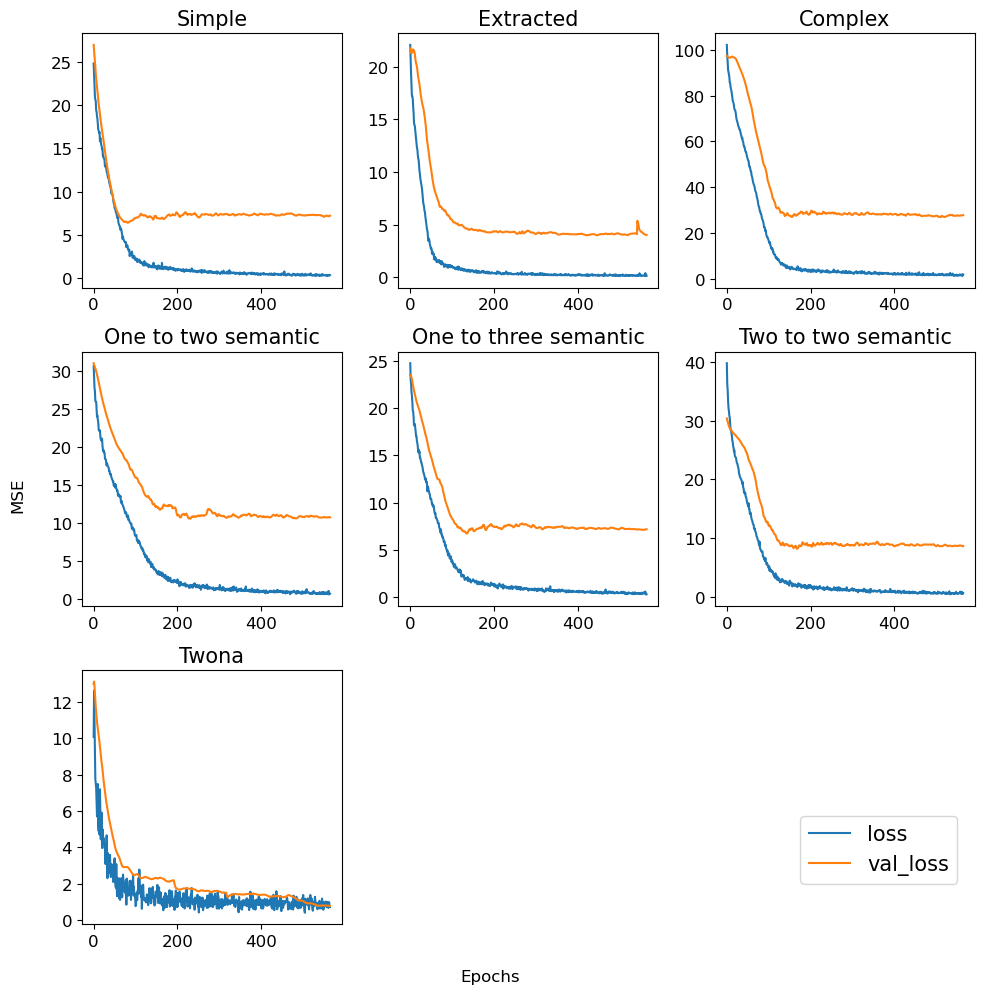

In [67]:
history_dict['Twona'] = history
p1 = ['Simple','Extracted','Complex','Semantic_tri','Semantic_quad3','Semantic_quad2','Twona']
plt_name = ['Simple','Extracted','Complex','One to two semantic','One to three semantic','Two to two semantic','Twona']
compar_plts(list(map(history_dict.get, p1)),['loss','val_loss'] ,plt_name )



In [30]:
for res,nam in zip(history_dict,plt_name):
    print(f'{nam}\nLoss : {history_dict[res].history["loss"][-1]}\tValidation loss : {history_dict[res].history["val_loss"][-1]}')

Simple
Loss : 0.3539268374443054	Validation loss : 7.216665267944336
Extracted
Loss : 0.14185261726379395	Validation loss : 4.017050266265869
Complex
Loss : 1.7868013381958008	Validation loss : 27.719736099243164
One to two semantic
Loss : 0.696977972984314	Validation loss : 10.737541198730469
One to three semantic
Loss : 0.31379789113998413	Validation loss : 7.180593013763428
Two to two semantic
Loss : 0.697440505027771	Validation loss : 8.67990493774414
Twona
Loss : 0.7135066986083984	Validation loss : 0.7737202644348145


C:\Users\Assaf\AppData\Local\Temp\ipykernel_5720\3121627278.py:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(labels, handles =handles,loc='lower left',fontsize="15" ,bbox_to_anchor=(0.8,0.1) ,ncol=1, bbox_transform=fig.transFigure)


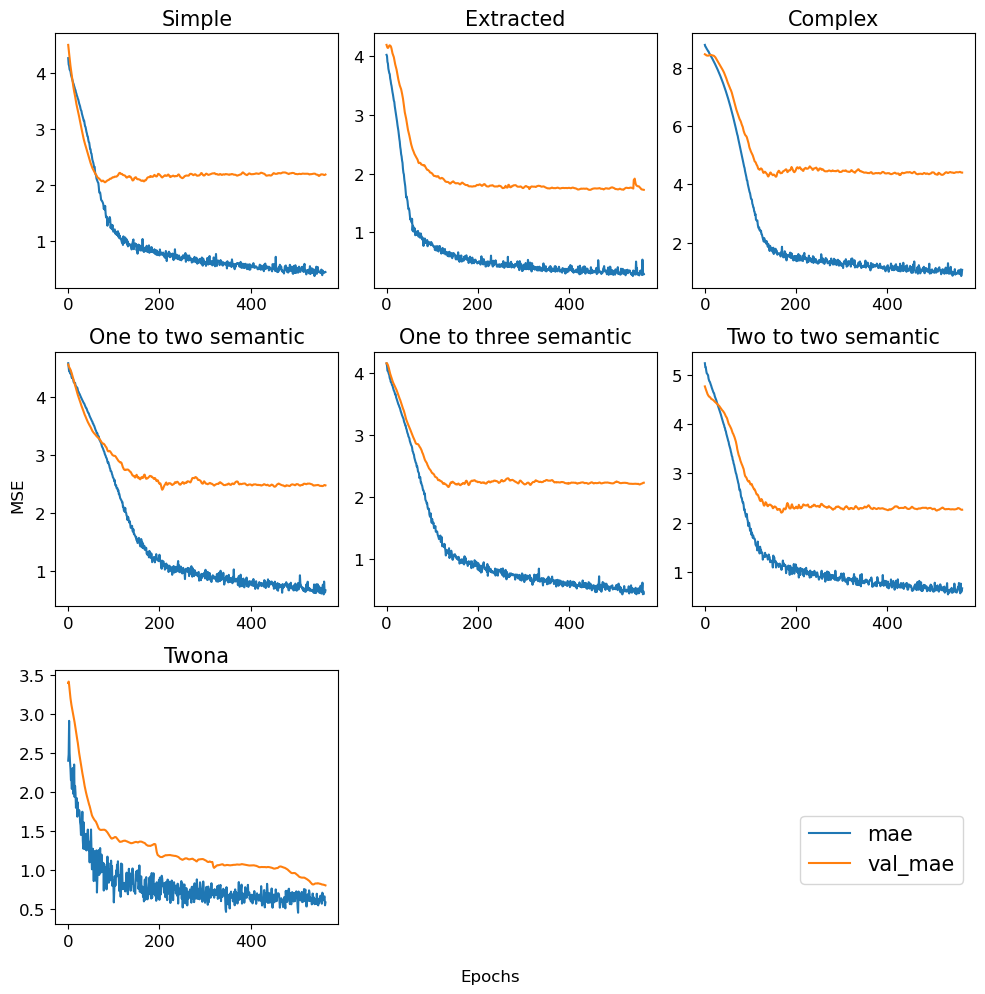

In [68]:
compar_plts(list(map(history_dict.get, p1)),['mae','val_mae'],plt_name )

In [32]:
for res,nam in zip(history_dict,plt_name):
    print(f'{nam}\nMAE : {history_dict[res].history["mae"][-1]}\tValidation MAE : {history_dict[res].history["val_mae"][-1]}')

Simple
MAE : 0.44625282287597656	Validation MAE : 2.1897547245025635
Extracted
MAE : 0.2897340655326843	Validation MAE : 1.7231919765472412
Complex
MAE : 1.0591248273849487	Validation MAE : 4.4075846672058105
One to two semantic
MAE : 0.6718341708183289	Validation MAE : 2.4758260250091553
One to three semantic
MAE : 0.4424648582935333	Validation MAE : 2.230282783508301
Two to two semantic
MAE : 0.6680233478546143	Validation MAE : 2.2623298168182373
Twona
MAE : 0.5869753360748291	Validation MAE : 0.8051550388336182


## Model exploration

### Creating Integrated Gradients

In [33]:
# Code snippet adapted from alibi library documentation: 
# https://docs.seldon.io/projects/alibi/en/stable/examples/integrated_gradients_imdb.html

explanations = []

X_test = onehot_padding(X_test,wrd_dict)
# Predicting test data
prediction = nn(X_test)
# Selecting embedding layers 
embd_layers = nn.layers[13:26]
# Looping through embedding layers calculating the attribution in regards to the test data 
for layer in embd_layers:
    n_steps = 50
    method = "gausslegendre"
    internal_batch_size = 100
    nb_samples = 10
    ig  = IntegratedGradients(nn,
                            layer=layer,
                            n_steps=n_steps,    
                            method=method,
                            internal_batch_size=internal_batch_size)
    predictions = nn(X_test).numpy().argmax(axis=1)
    explanations.append(ig.explain(X_test,
                            baselines=None,
                            target=predictions,
                            attribute_to_layer_inputs=False))


In [34]:
## Creating inverse dictionary  
invrs_dict = {
    outer_key : {v:k  for k,v in in_dict.items()} 
    for outer_key,in_dict  in wrd_dict.items() 
    }


In [35]:
## Summing up attributions from embedding layer
attrs_sum = []
for exp in explanations:
    attrs_sum.append(exp.attributions[0].sum(axis=2))


In [36]:
def  hlstr(string, color='white'):
    return f"<mark style=background-color:{color}>{string} </mark>"


def colorize(attrs, cmap='PiYG'):
    #Compute hex colors based on the attributions for a single instance.
    
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

def decode_sentence(x, reverse_index):
    return " ".join([reverse_index.get(i, 'UNK') for i in x])


In [37]:
### Color each feature of sentence according to its attribution  
for x in range(0,np.array(X_test).shape[1]):
    print(f'Sentence {x}')
    for data_clmn, dict_clmn in zip(range(0,len(X_test)),invrs_dict):
        x_i = np.trim_zeros(X_test[data_clmn][x])
        attrs_i = np.trim_zeros(attrs_sum[data_clmn][x])
        words = decode_sentence(x_i, invrs_dict[dict_clmn]).split()
        colors = colorize(attrs_i)
        display(HTML(f'<span>{dict_clmn}:\t</span>' +("".join(list(map(hlstr,words, colors))))))


Sentence 0


Sentence 1


Sentence 2


Sentence 3


Sentence 4


Sentence 5


### Squared root mean error

In [38]:
np.sqrt(np.mean((nn.predict(X_test).flat - y_test)**2))

1/1 [==============================] - 1s 512ms/step


3.7404273604889524

### Unique words in Dict

In [39]:
uniq_wrd = np.unique(sum([[x for x,r in v.items()]for k,v in wrd_dict.items()],[]))
print(f'There are {len(uniq_wrd)} unique words which are \n{uniq_wrd}')

There are 215 unique words which are 
[' Austria' ' Belgium' ' Canada' ' Finland' ' Ireland' ' Luxembourg'
 ' New Zealand' ' Sweden' ' Switzerland' 'AMS' 'Anywhere' 'Archiving'
 'Art' 'Artwork' 'Asana' 'Assurance' 'Audit' 'Australia' 'Automate'
 'Automatic' 'Automations' 'Available' 'Build' 'Built' 'Business' 'Change'
 'Cloud' 'Code' 'Coding' 'Collaborate' 'Compare' 'Comparison' 'Configure'
 'Connect' 'Control' 'Cost' 'Custom' 'Customizable' 'Dashboard' 'Design'
 'Device' 'Differences' 'Docs' 'Download' 'Drag' 'Drop' 'Easily' 'Easy'
 'Efficiency' 'Efficient' 'End' 'Esko' 'Everything' 'Faster' 'Features'
 'Find' 'Font' 'Food' 'France' 'Free' 'Germany' 'Get' 'Global' 'Google'
 'Graphic' 'Improve' 'Inclusive' 'Integrate' 'Integrations' 'List' 'Love'
 'Made' 'Make' 'Manage' 'Management' 'Map' 'Minutes' 'Necessary' 'Need'
 'Norway' 'One' 'Operations' 'Outlook' 'Overview' 'PDF' 'PNG' 'Packaging'
 'Packing' 'Perfect' 'Pharma' 'Pipeline' 'Plan' 'Plans' 'Platform' 'Pre'
 'Pricing' 'Productive' 

### Embedding weight analysis

In [40]:
category_map = {
    list(wrd_dict.keys()).index(outer_key) : list(in_dict.keys())
    for outer_key,in_dict  in wrd_dict.items() 
    }

In [41]:
embd_layers_weight = [emb.get_weights()[0] for emb in embd_layers ]
label_emb = list(df.columns[:-1])
embedding_magnitudes = [(np.sum(np.abs(emb).sum(axis=1) ) / emb.shape[0] /emb.shape[1])  for emb in embd_layers_weight]



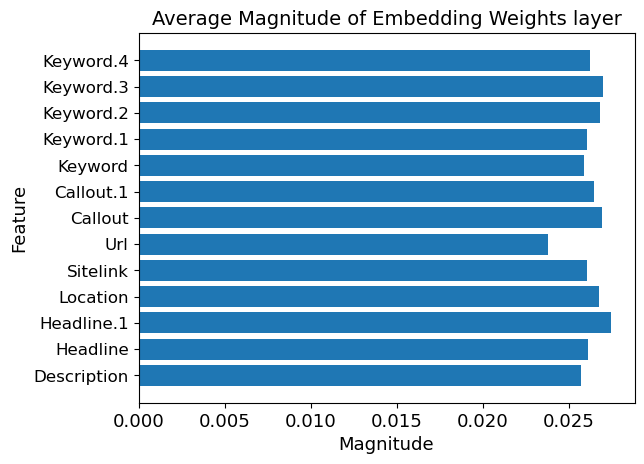

In [73]:
plt.yticks(range(0,len(embedding_magnitudes)) ,label_emb,fontsize = 12)
plt.barh(np.arange(0,len(embedding_magnitudes)),embedding_magnitudes)
plt.ylabel('Feature',fontsize = 13)
plt.xticks(fontsize = 13)
plt.xlabel('Magnitude',fontsize = 13)
plt.title('Average Magnitude of Embedding Weights layer',fontsize = 14)
plt.show()
